In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option('max_columns', 200)
%matplotlib inline


from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [2]:
# import data
data_week = pd.read_csv('date_to_week_id_map.csv')
product = pd.read_csv('product_prices.csv')

In [3]:
data_week.head()

,date,week_id
0,2012-01-01,49
1,2012-01-02,49
2,2012-01-03,49
3,2012-01-04,49
4,2012-01-05,49


In [4]:
product.head()

,outlet,product_identifier,week_id,sell_price
0,111,74,49,2.94
1,111,74,50,2.94
2,111,74,51,2.94
3,111,74,52,2.94
4,111,74,53,2.94


In [5]:
# merge both data
merged_data = pd.merge(product,data_week, on=['week_id'], how='inner')
merged_data.head()

,outlet,product_identifier,week_id,sell_price,date
0,111,74,49,2.94,2012-01-01
1,111,74,49,2.94,2012-01-02
2,111,74,49,2.94,2012-01-03
3,111,74,49,2.94,2012-01-04
4,111,74,49,2.94,2012-01-05


In [6]:
# import train and test data
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [7]:
train_df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales
0,2012-01-01,74,11,others,111,Maharashtra,0
1,2012-01-01,337,11,others,111,Maharashtra,1
2,2012-01-01,423,12,others,111,Maharashtra,0
3,2012-01-01,432,12,others,111,Maharashtra,0
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0


In [8]:
test_df.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state
0,1,2014-03-01,74,11,others,111,Maharashtra
1,2,2014-03-01,337,11,others,111,Maharashtra
2,3,2014-03-01,423,12,others,111,Maharashtra
3,4,2014-03-01,432,12,others,111,Maharashtra
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra


In [9]:
sample_submission.head()

,id,sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [10]:
# we will be merging the merged_date to train_df
train_df = pd.merge(train_df,merged_data, on=['date','product_identifier','outlet'], how='inner')

In [11]:
train_df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88


In [12]:
# # we will be merging the merged_date to test_df
test_df = pd.merge(test_df,merged_data, on=['date','product_identifier','outlet'], how='inner')

In [13]:
test_df.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price
0,1,2014-03-01,74,11,others,111,Maharashtra,162,3.43
1,2,2014-03-01,337,11,others,111,Maharashtra,162,7.78
2,3,2014-03-01,423,12,others,111,Maharashtra,162,0.97
3,4,2014-03-01,432,12,others,111,Maharashtra,162,4.97
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra,162,4.88


In [14]:
print(train_df.shape)
print(test_df.shape)

(395000, 9)
(15500, 9)


## EDA ON TRAIN DATA

In [15]:
# missing data
train_df.isnull().sum()

date                     0
product_identifier       0
department_identifier    0
category_of_product      0
outlet                   0
state                    0
sales                    0
week_id                  0
sell_price               0
dtype: int64

In [16]:
# data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395000 entries, 0 to 394999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   395000 non-null  object 
 1   product_identifier     395000 non-null  int64  
 2   department_identifier  395000 non-null  int64  
 3   category_of_product    395000 non-null  object 
 4   outlet                 395000 non-null  int64  
 5   state                  395000 non-null  object 
 6   sales                  395000 non-null  int64  
 7   week_id                395000 non-null  int64  
 8   sell_price             395000 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 27.1+ MB


In [17]:
# convert the date column to datatype
import datetime as dt
train_df['date'] = pd.to_datetime(train_df['date'])

# extract the year, month and quarter in the date column
train_df['date_year'] = train_df['date'].dt.year # the data contains 3 years stock prices 2011, 2012, 2013
train_df['days_in_month'] = train_df['date'].dt.month # where 1 == January, 2 = Febuary, ... December == 12
train_df['quarter'] = train_df['date'].dt.quarter # in a year we have 4 quaters 1, 2, 3, 4
train_df['weekday'] = train_df['date'].dt.weekday # where Monday == 0, Tuesday == 1, ... Sunday == 6

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395000 entries, 0 to 394999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   395000 non-null  datetime64[ns]
 1   product_identifier     395000 non-null  int64         
 2   department_identifier  395000 non-null  int64         
 3   category_of_product    395000 non-null  object        
 4   outlet                 395000 non-null  int64         
 5   state                  395000 non-null  object        
 6   sales                  395000 non-null  int64         
 7   week_id                395000 non-null  int64         
 8   sell_price             395000 non-null  float64       
 9   date_year              395000 non-null  int32         
 10  days_in_month          395000 non-null  int32         
 11  quarter                395000 non-null  int32         
 12  weekday                395000 non-null  int3

In [19]:
# Here i used strftime to extract the day and month name of my date for my analysis
train_df['date_info'] = train_df['date'].dt.strftime('%d-%A-%B-%Y') # create a ne column data_info to store my strftime date
train_df['dayname'] = train_df['date_info'].str.split('-', expand = True)[1] # assign the day name
train_df['mnthname'] = train_df['date_info'].str.split('-', expand = True)[2] # assisgn the month name
train_df['year_str'] = train_df['date_info'].str.split('-', expand = True)[3] # assisgn the month name

In [20]:
# # drop the date_info, date, department_identifiercolumn
# train_df.drop(['date_info', 'department_identifier'],  axis = 1, inplace = True)

In [21]:
train_df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price,date_year,days_in_month,quarter,weekday,date_info,dayname,mnthname,year_str
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88,2012,1,1,6,01-Sunday-January-2012,Sunday,January,2012


In [22]:
# let check the category of date we have
print(f'We have {train_df['category_of_product'].nunique()} unique categories of products')

We have 3 unique categories of products


In [23]:
# check the value counts of each category of date
train_df['category_of_product'].value_counts()

category_of_product
fast_moving_consumer_goods    229100
drinks_and_food               134300
others                         31600
Name: count, dtype: int64

In [24]:
# check number of outlets for this company in India
print(f'We have {train_df['outlet'].nunique()} unique outlets')

We have 10 unique outlets


In [25]:
# check the value counts of each outlet
# train_df['outlet'].value_counts()

In [26]:
# check the number states the company is located in india
print(f'The company is located in {train_df['state'].nunique()} states across India')

The company is located in 3 states across India


In [27]:
# list the states the company is located in India
train_df['state'].value_counts().index.tolist()

['Maharashtra', 'Telangana', 'Kerala']

In [28]:
# check the statistics of the numerical data
train_df.describe()

,date,product_identifier,department_identifier,outlet,sales,week_id,sell_price,date_year,days_in_month,quarter,weekday
count,395000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000,395000.000000
mean,2013-01-29 12:00:00,1509.960000,24.460000,211.200000,1.228919,105.070886,4.987644,2012.611392,6.143038,2.394937,2.997468
min,2012-01-01 00:00:00,74.000000,11.000000,111.000000,0.000000,49.000000,0.050000,2012.000000,1.000000,1.000000,0.000000
25%,2012-07-16 00:00:00,926.000000,21.000000,113.000000,0.000000,77.000000,2.680000,2012.000000,3.000000,1.000000,1.000000
50%,2013-01-29 12:00:00,1325.000000,22.000000,221.500000,0.000000,105.000000,3.980000,2013.000000,6.000000,2.000000,3.000000
75%,2013-08-15 00:00:00,1753.000000,31.000000,331.000000,1.000000,133.000000,6.480000,2013.000000,9.000000,3.000000,5.000000
max,2014-02-28 00:00:00,3021.000000,33.000000,333.000000,293.000000,161.000000,44.360000,2014.000000,12.000000,4.000000,6.000000
std,NaN,809.799518,6.337863,91.161291,3.595266,32.578749,3.874444,0.622061,3.576092,1.145593,2.000001


## DATA VISUALIZATION

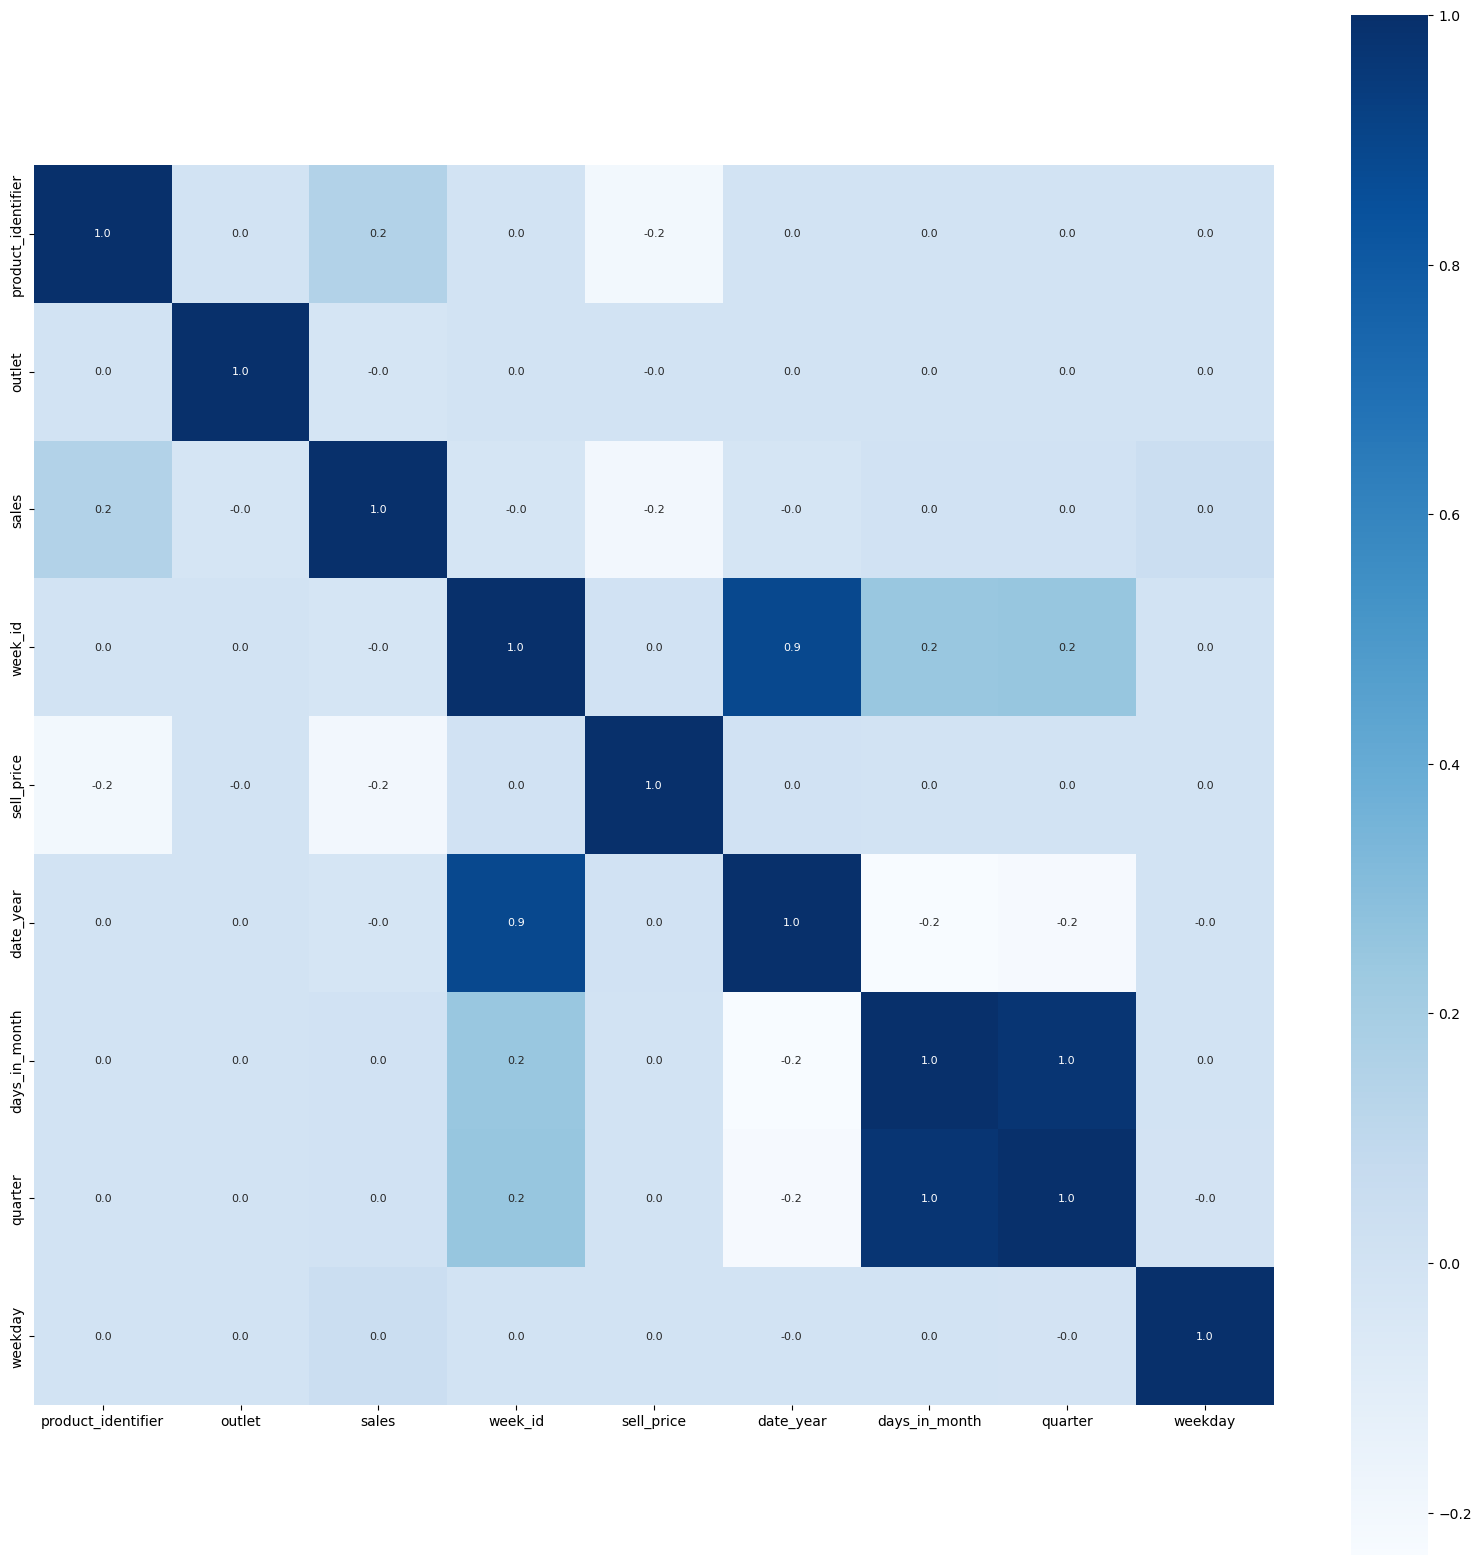

In [29]:
# let check the correlations of the features in our data
num_data = ['product_identifier', 'outlet', 'sales', 'week_id', 'sell_price', 'date_year', 'days_in_month', 'quarter', 'weekday']
train_num = train_df[num_data]
correlation = train_num.corr()
# train_num.head()


#constructing a heat  to understand the correlation
plt.figure(figsize=(20,20))
sns.heatmap(correlation, cbar=True,square = True, fmt = '.1f', annot = True, annot_kws={'size':8}, cmap='Blues');

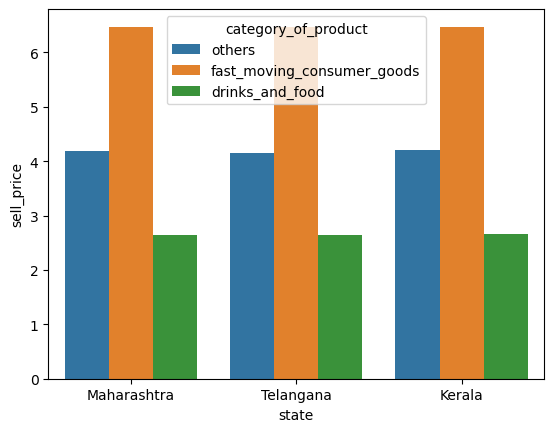

In [30]:
# check for sales across states by product category
sns.barplot(x = 'state',
            y = 'sell_price',
            hue = 'category_of_product',
            data = train_df,
            # estimator = np.median,
            errorbar=('ci', 0));

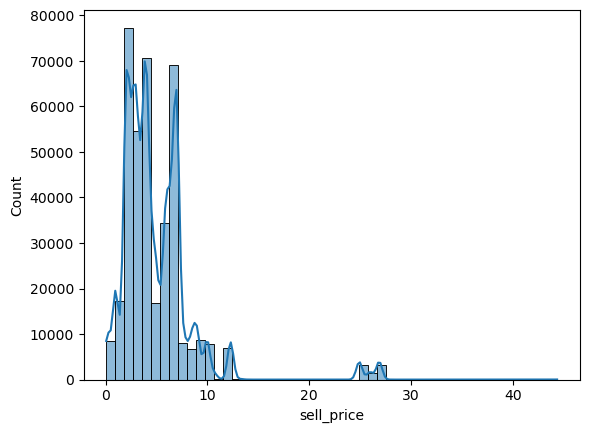

In [31]:
sns.histplot(data=train_df, x="sell_price", kde=True, bins=50);

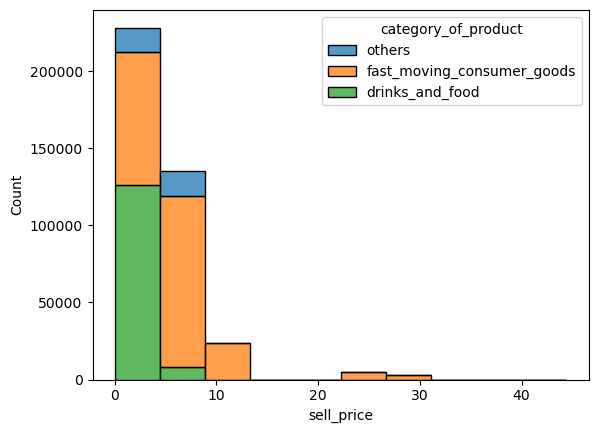

In [32]:
sns.histplot(data=train_df, x="sell_price", hue="category_of_product", multiple="stack", bins=10);

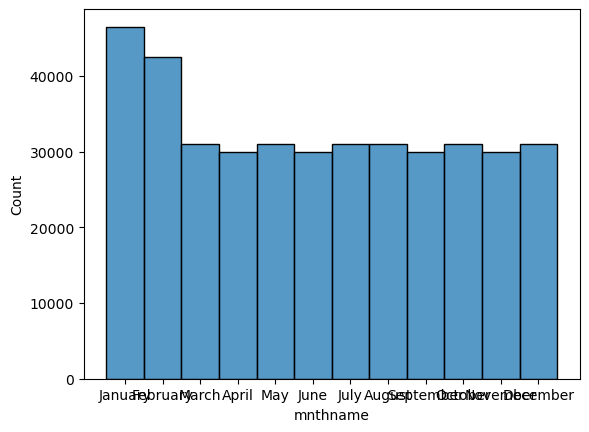

In [33]:
sns.histplot(data=train_df, x="mnthname", bins=10);

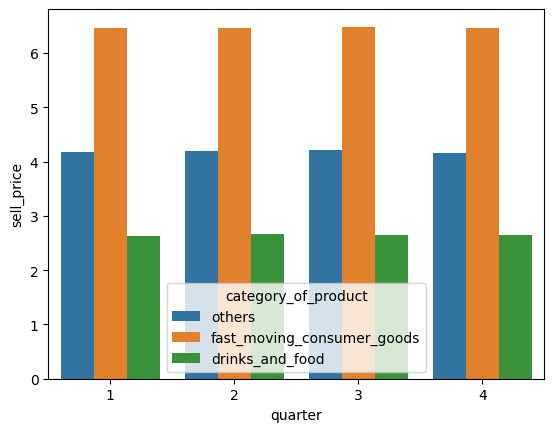

In [34]:
# check for sales across quarters by product category
sns.barplot(x = 'quarter',
            y = 'sell_price',
            hue = 'category_of_product',
            data = train_df,
            # estimator = np.median,
            errorbar=('ci', 0));

In [35]:
train_df.groupby('state')['sell_price'].sum()

state
Kerala         591171.32
Maharashtra    788347.05
Telangana      590600.83
Name: sell_price, dtype: float64

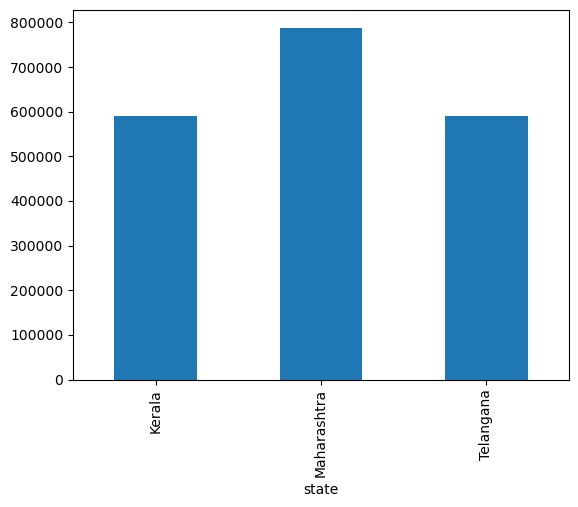

In [36]:
train_df.groupby('state')['sell_price'].sum().plot(kind = 'bar');

In [37]:
train_df.groupby('year_str')['sell_price'].sum()

year_str
2012    908199.84
2013    915250.91
2014    146668.45
Name: sell_price, dtype: float64

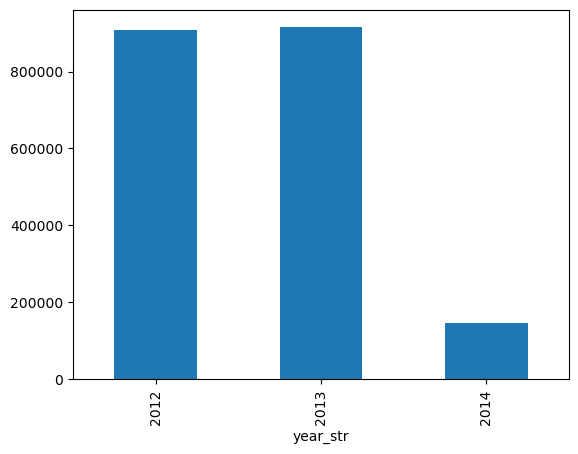

In [38]:
train_df.groupby('year_str')['sell_price'].sum().plot(kind = 'bar'); #figsize=(10,6))

In [39]:
train_df.groupby('mnthname')['sell_price'].sum()

mnthname
April        149699.47
August       154738.51
December     154695.57
February     211637.06
January      231190.09
July         155577.12
June         149870.97
March        154845.92
May          154665.11
November     149474.15
October      154234.56
September    149490.67
Name: sell_price, dtype: float64

<Axes: xlabel='mnthname'>

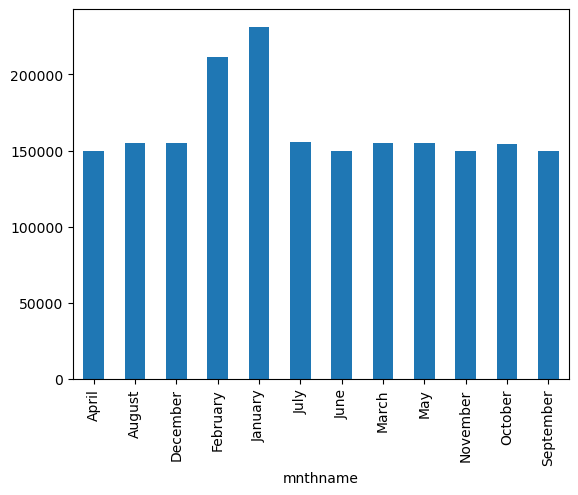

In [40]:
train_df.groupby('mnthname')['sell_price'].sum().plot(kind = 'bar')

In [41]:
# train_df.groupby('dayname')['sell_price'].sum()

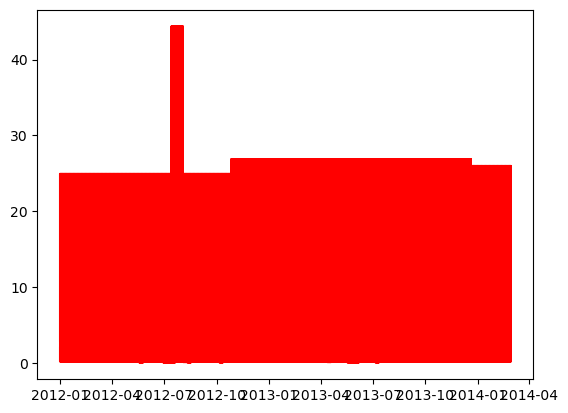

In [42]:
plt.plot(train_df.date, train_df.sell_price, color='red');

In [43]:
# drop columes not needed on train fataframe
# train_df.columns

In [44]:
# get the target data
target = train_df['sales']

In [45]:
target

0         0
1         1
2         0
3         0
4         0
         ..
394995    2
394996    8
394997    0
394998    0
394999    0
Name: sales, Length: 395000, dtype: int64

In [46]:
# # drop the date_info, date, department_identifiercolumn
train_df.drop(['date_info', 'department_identifier', 'dayname', 'mnthname', 'year_str', 'date_year'],  axis = 1, inplace = True)

In [47]:
train_df.head()

,date,product_identifier,category_of_product,outlet,state,sales,week_id,sell_price,days_in_month,quarter,weekday
0,2012-01-01,74,others,111,Maharashtra,0,49,2.94,1,1,6
1,2012-01-01,337,others,111,Maharashtra,1,49,7.44,1,1,6
2,2012-01-01,423,others,111,Maharashtra,0,49,0.97,1,1,6
3,2012-01-01,432,others,111,Maharashtra,0,49,4.97,1,1,6
4,2012-01-01,581,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88,1,1,6


In [48]:
# train_df.info()

## EDA ON TEST DATA

In [49]:
test_df.head()

,id,date,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price
0,1,2014-03-01,74,11,others,111,Maharashtra,162,3.43
1,2,2014-03-01,337,11,others,111,Maharashtra,162,7.78
2,3,2014-03-01,423,12,others,111,Maharashtra,162,0.97
3,4,2014-03-01,432,12,others,111,Maharashtra,162,4.97
4,5,2014-03-01,581,21,fast_moving_consumer_goods,111,Maharashtra,162,4.88


In [50]:
# convert date column to date datatype
test_df['date'] = pd.to_datetime(test_df['date'])

# extract the year, month and quarter in the date column
test_df['date_year'] = test_df['date'].dt.year # the data contains 3 years stock prices 2011, 2012, 2013
test_df['days_in_month'] = test_df['date'].dt.month # where 1 == January, 2 = Febuary, ... December == 12
test_df['quarter'] = test_df['date'].dt.quarter # in a year we have 4 quaters 1, 2, 3, 4
test_df['weekday'] = test_df['date'].dt.weekday # where Monday == 0, Tuesday == 1, ... Sunday == 6

In [51]:
# test_df.head()

In [52]:
# # drop the date_info, date, department_identifiercolumn
test_df.drop(['department_identifier', 'date_year'],  axis = 1, inplace = True)

In [53]:
print(train_df.shape)
print(test_df.shape)

(395000, 11)
(15500, 11)


In [54]:
test_df.head()

,id,date,product_identifier,category_of_product,outlet,state,week_id,sell_price,days_in_month,quarter,weekday
0,1,2014-03-01,74,others,111,Maharashtra,162,3.43,3,1,5
1,2,2014-03-01,337,others,111,Maharashtra,162,7.78,3,1,5
2,3,2014-03-01,423,others,111,Maharashtra,162,0.97,3,1,5
3,4,2014-03-01,432,others,111,Maharashtra,162,4.97,3,1,5
4,5,2014-03-01,581,fast_moving_consumer_goods,111,Maharashtra,162,4.88,3,1,5


In [55]:
print(train_df.columns)
print(test_df.columns)

Index(['date', 'product_identifier', 'category_of_product', 'outlet', 'state',
       'sales', 'week_id', 'sell_price', 'days_in_month', 'quarter',
       'weekday'],
      dtype='object')
Index(['id', 'date', 'product_identifier', 'category_of_product', 'outlet',
       'state', 'week_id', 'sell_price', 'days_in_month', 'quarter',
       'weekday'],
      dtype='object')


In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395000 entries, 0 to 394999
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 395000 non-null  datetime64[ns]
 1   product_identifier   395000 non-null  int64         
 2   category_of_product  395000 non-null  object        
 3   outlet               395000 non-null  int64         
 4   state                395000 non-null  object        
 5   sales                395000 non-null  int64         
 6   week_id              395000 non-null  int64         
 7   sell_price           395000 non-null  float64       
 8   days_in_month        395000 non-null  int32         
 9   quarter              395000 non-null  int32         
 10  weekday              395000 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(4), object(2)
memory usage: 28.6+ MB


In [57]:
# numerical and categorical features of train data
num_feat = ['outlet', 'week_id', 'sell_price', 'days_in_month', 'quarter', 'weekday']
cat_feat = ['category_of_product', 'state']

In [58]:
test_df[cat_feat].head()

,category_of_product,state
0,others,Maharashtra
1,others,Maharashtra
2,others,Maharashtra
3,others,Maharashtra
4,fast_moving_consumer_goods,Maharashtra


## SCALE NUMERICAL DATA

In [59]:
sc = StandardScaler() #
cols = num_feat

X = sc.fit_transform(train_df[num_feat])
testing = sc.transform(test_df[num_feat])

X = pd.DataFrame(data=X, columns=cols)
testing = pd.DataFrame(data=testing, columns=cols)

In [60]:
# checking the scaled value
X.head()

,outlet,week_id,sell_price,days_in_month,quarter,weekday
0,-1.099152,-1.72109,-0.528501,-1.438175,-1.217657,1.501267
1,-1.099152,-1.72109,0.632958,-1.438175,-1.217657,1.501267
2,-1.099152,-1.72109,-1.036961,-1.438175,-1.217657,1.501267
3,-1.099152,-1.72109,-0.004554,-1.438175,-1.217657,1.501267
4,-1.099152,-1.72109,-0.027783,-1.438175,-1.217657,1.501267


## Building Our Model

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.33, random_state=42)

In [62]:
# classifier = LogisticRegression(random_state=16, max_iter= 1000)
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.42,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [63]:
xg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.42, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [64]:
pred_train = xg.predict(X_train)
pred_test = xg.predict(X_test)

In [65]:
RMSE_test = np.sqrt(mean_squared_error(y_test, pred_test))
RMSE_train = np.sqrt(mean_squared_error(y_train, pred_train))

In [66]:
print('Train set Evaluation')
print('The classifier RMSE score {}\n'.format(RMSE_train)) 

print('Test set Evaluation')
print('The classifier RMSE score {}'.format(RMSE_test))

Train set Evaluation
The classifier RMSE score 3.254313923834089

Test set Evaluation
The classifier RMSE score 3.297453823809909


In [67]:
# submission_file = sample_submission.copy()

In [68]:
# submission_file.sales = xg.predict(testing)

In [69]:
# submission_file.head()